In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [76]:
# custom loss function, taking into account the RGB values
# 효과는 크게 없었지만, 논리적으로는 맞는 부분인 것 같음.

from tensorflow.keras import backend as K

# Custom loss function that applies MSE specifically to RGB channels
def mse_rgb(y_true, y_pred):
    # y_true and y_pred are assumed to be in shape (batch_size, height, width, 3)
    return K.mean(K.square(y_true - y_pred), axis=-1)

In [77]:
# more pooling with stride instead of GAP2D

def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    
    # Reshape to the desired output shape (frames, height, width, channels)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss=mse_rgb, metrics=['mae'])
    return model

In [78]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 2

In [79]:
def process_sprite_data(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    X (numpy array): Array of input frames (first frame of each animation sequence).
    Y (numpy array): Array of output frames (remaining frames of each animation sequence).
    """
    # Initialize lists for input (X) and output (Y) frames
    X = []
    Y = []
    
    # Process each sprite sheet in the provided paths
    for i in range(len(sprite_sheet_paths)):
        sprite_sheet = Image.open(sprite_sheet_paths[i])
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        
        # Calculate the width and height of each frame
        frame_width = sheet_width // num_frames
        frame_height = sheet_height  # Height of each frame is the same as the height of the sprite sheet
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Calculate the coordinates of the sprite in the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            # Crop the sprite from the sprite sheet
            frame = sprite_sheet.crop((left, upper, right, lower))
            
            # Resize to 128x128 if needed and convert to RGB
            frame = frame.convert('RGB').resize((128, 128))
            
            # Normalize pixel values to [0, 1]
            frame_array = np.array(frame) / 255.0
            
            # Append the first frame to X and the remaining ones to Y
            if frame_num == 0:
                X.append(frame_array)  # The first frame goes into X
            else:
                if len(Y) <= i:  # Initialize the sublist for Y if necessary
                    Y.append([])
                Y[i].append(frame_array)  # Subsequent frames go into Y
    
    return np.array(X), np.array(Y)

sprite_sheet_paths = ['/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_3_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_3_10f/Walk.png'
                     ] 
num_frames = 10  # Number of frames in the sprite sheet
X, Y = process_sprite_data(sprite_sheet_paths, num_frames)

print(f"X shape: {X[1:].shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y shape: {Y[1:].shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X shape: (5, 128, 128, 3)
Y shape: (5, 9, 128, 128, 3)


In [84]:
type(X)

numpy.ndarray

In [80]:
# Train the model without the first example = X[1:], Y[1:]
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-24 17:03:10.549493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.2440 - mae: 0.4921 - val_loss: 0.2449 - val_mae: 0.4935
Epoch 2/50


2024-10-24 17:03:12.049718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 717ms/step - loss: 0.2438 - mae: 0.4920 - val_loss: 0.2443 - val_mae: 0.4929
Epoch 3/50
1/1 [==============================] - 1s 549ms/step - loss: 0.2432 - mae: 0.4914 - val_loss: 0.2399 - val_mae: 0.4883
Epoch 4/50
1/1 [==============================] - 1s 554ms/step - loss: 0.2388 - mae: 0.4868 - val_loss: 0.2043 - val_mae: 0.4497
Epoch 5/50
1/1 [==============================] - 0s 486ms/step - loss: 0.2034 - mae: 0.4483 - val_loss: 0.0646 - val_mae: 0.2427
Epoch 6/50
1/1 [==============================] - 1s 503ms/step - loss: 0.0648 - mae: 0.2423 - val_loss: 0.0087 - val_mae: 0.0222
Epoch 7/50
1/1 [==============================] - 1s 573ms/step - loss: 0.0114 - mae: 0.0259 - val_loss: 0.0098 - val_mae: 0.0180
Epoch 8/50
1/1 [==============================] - 1s 635ms/step - loss: 0.0128 - mae: 0.0221 - val_loss: 0.0140 - val_mae: 0.0198
Epoch 9/50
1/1 [==============================] - 1s 596ms/step - loss: 0.0167 - mae: 0.0236 - val_lo

In [87]:
refine_train = []

for i in range(X.shape[0]):
    predicted_frames = model.predict(np.expand_dims(X[0], axis=0))  # Add batch dimension
    predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
    merged_frames = np.concatenate((np.expand_dims(X[i], axis=0), predicted_frames), axis=0)
    refine_train.append(np.expand_dims(merged_frames, axis=0))
    
# print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# # Optionally, save the predicted frames or display them
# for i in range(predicted_frames.shape[0]):
#     frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]

1/1 [==============================] - 0s 15ms/step


In [96]:
refine_train = np.concatenate(refine_train, axis=0) 
refine_train.shape

(6, 10, 128, 128, 3)

In [14]:
# def merge_frames(input_frame, output_frames):
#     """
#     Merge input_frame (1, 128, 128, 3) and output_frames (9, 128, 128, 3) into one array.
    
#     Parameters:
#     input_frame (numpy array): The first frame with shape (1, 128, 128, 3).
#     output_frames (numpy array): The rest of the frames with shape (9, 128, 128, 3).

#     Returns:
#     numpy array: Merged frames with shape (10, 128, 128, 3).
#     """    
#     # Concatenate the input frame with the output frames
#     merged_frames = np.concatenate(([input_frame], output_frames), axis=0)
    
#     return merged_frames

# merged_frames = merge_frames(X[0], predicted_frames)
# print("Merged shape:", merged_frames.shape)  # Expected Output: (10, 128, 128, 3)

Merged shape: (10, 128, 128, 3)


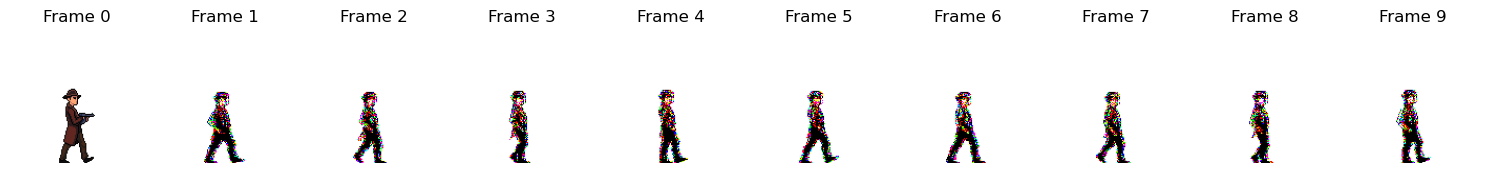

In [93]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

display_predicted_frames(refine_train[3][0])

In [ ]:
# def animate_frames(predicted_frames):
#     """
#     Create and display an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
#     )

#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())  # Display the animation in HTML format


# animate_frames(merged_frames)

In [17]:
# # saving gif file

# def animate_frames(predicted_frames, save_path=None, fps=5):
#     """
#     Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
#     fps (int, optional): Frames per second for the animation. Default is 5 fps.
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
#     )

#     if save_path:
#         # Save the animation
#         if save_path.endswith(".mp4"):
#             ani.save(save_path, writer="ffmpeg", fps=fps)
#         elif save_path.endswith(".gif"):
#             ani.save(save_path, writer="pillow", fps=fps)
#         print(f"Animation saved to {save_path}")
    
#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())

# animate_frames(merged_frames, '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/output/Stride_Conv.gif', fps=5)

In [69]:
from tensorflow.keras import layers, models

def build_refinement_model(input_shape, output_frames):
    """
    Builds a U-Net-like refinement model to clean up noisy generated frames.
    
    Parameters:
    input_shape (tuple): The shape of the input (frames, height, width, channels).
                         The first dimension is for the sequence of frames.
    output_frames (int): The number of frames to output.
    
    Returns:
    model: The compiled Keras refinement model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='refinement_input')
    
    # Encoder Block 1
    conv1 = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(encoder_input)
    pool1 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(conv1)
    
    # Encoder Block 2
    conv2 = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(pool1)
    pool2 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(conv2)
    
    # Encoder Block 3
    conv3 = layers.TimeDistributed(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))(pool2)
    pool3 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(conv3)
    
    # Latent Space (lowest resolution)
    latent = layers.TimeDistributed(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))(pool3)

    # Decoder Block 1 (Upsampling)
    up1 = layers.TimeDistributed(layers.UpSampling2D((2, 2)))(latent)
    dec1 = layers.TimeDistributed(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))(up1)
    
    # Adjust the shape of conv3 to match dec1
    conv3_reshaped = layers.TimeDistributed(layers.Conv2D(256, (1, 1), padding='same'))(conv3)  # Adjust spatial size
    
    # Skip connection
    dec1 = layers.Concatenate()([dec1, conv3_reshaped])  # Skip connection from Encoder Block 3
    
    # Decoder Block 2 (Upsampling)
    up2 = layers.TimeDistributed(layers.UpSampling2D((2, 2)))(dec1)
    dec2 = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(up2)
    
    # Adjust the shape of conv2 to match dec2
    conv2_reshaped = layers.TimeDistributed(layers.Conv2D(128, (1, 1), padding='same'))(conv2)  # Adjust spatial size
    
    # Skip connection
    dec2 = layers.Concatenate()([dec2, conv2_reshaped])  # Skip connection from Encoder Block 2

    # Decoder Block 3 (Upsampling)
    up3 = layers.TimeDistributed(layers.UpSampling2D((2, 2)))(dec2)
    dec3 = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(up3)
    
    # Adjust the shape of conv1 to match dec3
    conv1_reshaped = layers.TimeDistributed(layers.Conv2D(64, (1, 1), padding='same'))(conv1)  # Adjust spatial size
    
    # Skip connection
    dec3 = layers.Concatenate()([dec3, conv1_reshaped])  # Skip connection from Encoder Block 1

    # Output layer (restored clean frames)
    output = layers.TimeDistributed(layers.Conv2D(input_shape[-1], (1, 1), activation='sigmoid'))(dec3)  # Same channels as input
    
    # Build and compile the model
    model = models.Model(encoder_input, output, name='refinement_model')
    
    # Compile the model
    model.compile(optimizer='adam', loss=mse_rgb, metrics=['mae'])
    
    return model


In [70]:
total_frames = 10

# Define input shape as (frames, height, width, channels)
input_shape = (10, 128, 128, 3)  # Example: sequence of frames, each 128x128 with 3 channels (RGB)
output_frames = 10  # Example: number of frames

# Build the refinement model
refinement_model = build_refinement_model(input_shape, output_frames)
refinement_model.summary()

Model: "refinement_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 refinement_input (InputLay  [(None, 10, 128, 128, 3)]    0         []                            
 er)                                                                                              
                                                                                                  
 time_distributed_44 (TimeD  (None, 10, 128, 128, 64)     1792      ['refinement_input[0][0]']    
 istributed)                                                                                      
                                                                                                  
 time_distributed_45 (TimeD  (None, 10, 64, 64, 64)       0         ['time_distributed_44[0][0]'] 
 istributed)                                                                       

In [97]:
import numpy as np
from PIL import Image

def process_sprite_data_2(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    Y (numpy array): Array of all input frames (sprites) from each animation sequence.
    """
    # Initialize a list for output (Y) frames
    Y = []
    
    # Process each sprite sheet in the provided paths
    for i in range(len(sprite_sheet_paths)):
        sprite_sheet = Image.open(sprite_sheet_paths[i])
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        
        # Calculate the width and height of each frame
        frame_width = sheet_width // num_frames
        frame_height = sheet_height  # Height of each frame is the same as the height of the sprite sheet
        
        # Initialize a list for frames of the current sprite sheet
        current_sprite_frames = []
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Calculate the coordinates of the sprite in the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            # Crop the sprite from the sprite sheet
            frame = sprite_sheet.crop((left, upper, right, lower))
            
            # Resize to 128x128 if needed and convert to RGB
            frame = frame.convert('RGB').resize((128, 128))
            
            # Normalize pixel values to [0, 1]
            frame_array = np.array(frame) / 255.0
            
            # Append the frame to the current sprite frames list
            current_sprite_frames.append(frame_array)
        
        # Convert the current sprite frames to a NumPy array and reshape to (1, 10, 128, 128, 3)
        current_sprite_frames = np.array(current_sprite_frames)  # Shape will be (10, 128, 128, 3)
        current_sprite_frames = current_sprite_frames[np.newaxis, :]  # Add a new axis to make it (1, 10, 128, 128, 3)
        
        # Append the current sprite frames to Y
        Y.append(current_sprite_frames)

    # Convert Y to a NumPy array
    Y = np.array(Y)  # Shape will be (6, 1, 10, 128, 128, 3)

    # Reshape Y to (6, 10, 128, 128, 3) by removing the second dimension
    Y = Y.reshape(6, 10, 128, 128, 3)
    
    return Y

# Example usage
# sprite_sheet_paths = ['path_to_sheet1.png', 'path_to_sheet2.png', 'path_to_sheet3.png', 
#                        'path_to_sheet4.png', 'path_to_sheet5.png', 'path_to_sheet6.png']
# processed_data = process_sprite_data_2(sprite_sheet_paths, num_frames=10)


In [98]:
sprite_sheet_paths = ['/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_3_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_3_10f/Walk.png'
                     ] 
num_frames = 10  # Number of frames in the sprite sheet
Y = process_sprite_data_2(sprite_sheet_paths, num_frames)

print(f"Y shape: {Y.shape}")  # Should be (num_sequences, 9, 128, 128, 3)

Y shape: (6, 10, 128, 128, 3)


(10, 128, 128, 3) (10, 128, 128, 3)


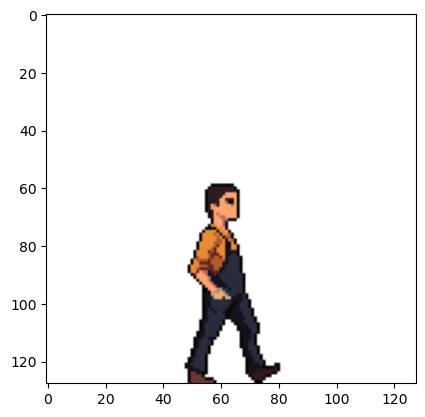

In [100]:
print(merged_frames.shape, Y[0].shape)
plt.imshow(Y[0][0]) # == X[0] for now

In [101]:
# Input shape error -> reshape(1, 10, 128, 128, 3) 으로 해결

refinement_model.fit(refine_train, Y, epochs=20, batch_size=1)

Epoch 1/20
6/6 [==============================] - 5s 759ms/step - loss: 0.0413 - mae: 0.0472
Epoch 2/20
6/6 [==============================] - 5s 786ms/step - loss: 0.0413 - mae: 0.0472
Epoch 3/20
6/6 [==============================] - 4s 671ms/step - loss: 0.0413 - mae: 0.0472
Epoch 4/20
6/6 [==============================] - 4s 692ms/step - loss: 0.0413 - mae: 0.0472
Epoch 5/20
6/6 [==============================] - 5s 761ms/step - loss: 0.0413 - mae: 0.0472
Epoch 6/20
6/6 [==============================] - 4s 688ms/step - loss: 0.0413 - mae: 0.0472
Epoch 7/20
6/6 [==============================] - 4s 683ms/step - loss: 0.0413 - mae: 0.0472
Epoch 8/20
6/6 [==============================] - 4s 668ms/step - loss: 0.0413 - mae: 0.0472
Epoch 9/20
6/6 [==============================] - 5s 801ms/step - loss: 0.0413 - mae: 0.0472
Epoch 10/20
6/6 [==============================] - 4s 708ms/step - loss: 0.0413 - mae: 0.0472
Epoch 11/20
6/6 [==============================] - 4s 680ms/step - lo

In [102]:
# Should input (None, n of frames, 128, 128, 3)
refined_frames = refinement_model.predict(np.expand_dims(refine_train[0], axis=0))  # Add batch dimension

# Post-process the predicted frames if necessary
refined_frames = refined_frames.squeeze()  # Remove the batch dimension if needed
print(f"Refined frames shape: {refined_frames.shape}")  # Should be (10, 128, 128, 3)

# Check the range of the output values
print(f"Output range: min={refined_frames.min()}, max={refined_frames.max()}")

for i in range(refined_frames.shape[0]):
    (refined_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]

1/1 [==============================] - 0s 197ms/step
Refined frames shape: (10, 128, 128, 3)
Output range: min=1.0, max=1.0


In [65]:
refined_frames.max()

1.0

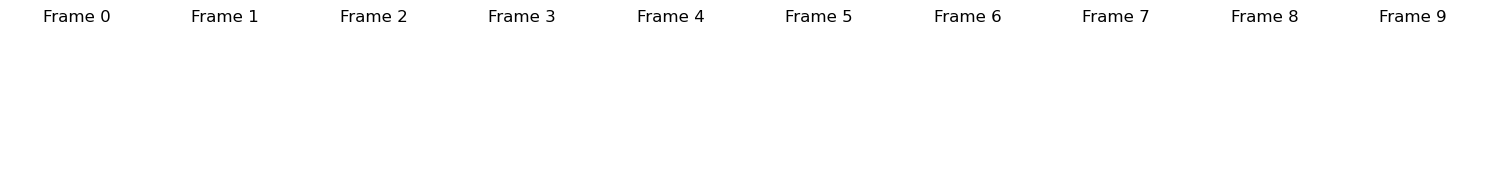

In [103]:
display_predicted_frames(refined_frames)